In [1]:
import sys
sys.path.append('../')
from rocket_rag.utils import *
from rocket_rag.data_processing import *

c:\Users\s381731\AppData\Local\miniconda3\envs\agents\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def compute_top_5_accuracy(y_test, y_pred):
    """
    
    """
    sum = 0 
    for i in range(len(y_pred)):
        top_k = []
        if y_test[i] == 0:
            top_k.append(0)
        elif y_test[i] in [1,2]:
            top_k.extend([1,2])
        elif y_test[i] in [3,4]:
             top_k.extend([3,4])
        elif y_test[i] > 4: 
             deb = y_test[i] - 2
             fin = y_test[i] + 2
             if fin >12:
                 deb = deb - (fin-12)
                 fin = 12
             if deb < 5:
                fin = fin + 5- deb
                deb = 5
             top_k.extend(list(range(deb,fin+1)))
        if y_pred[i] in top_k:
            sum = sum + 1
    return sum/len(y_pred)

### Load all data

In [3]:
train_files_dict = parse_files(main_directory=INSTANCES_DIR)
test_files_dict = parse_files(main_directory=INFERENCE_DIR)

In [4]:
list(train_files_dict.keys())

['20kg', '40kg', '-40kg']

In [5]:
train_files_ls = [file for _, files in train_files_dict.items() for file in files]
test_files_ls = [file for _, files in test_files_dict.items() for file in files]

In [17]:
train_files_ls[:5]

['../data/instances/20kg\\normal\\normal_20_10_1.csv',
 '../data/instances/20kg\\normal\\normal_20_10_3.csv',
 '../data/instances/20kg\\normal\\normal_20_10_4.csv',
 '../data/instances/20kg\\normal\\normal_20_10_5.csv',
 '../data/instances/20kg\\normal\\normal_20_1_5.csv']

### Construct the dataset

In [7]:
# X_train, y_train = construct_dataset(train_files_ls)
# X_test, y_test = construct_dataset(test_files_ls)

  0%|          | 0/1556 [00:00<?, ?it/s]

100%|██████████| 389/389 [00:00<00:00, 490.28it/s]


In [69]:
load = '40kg'
X_train, y_train = construct_dataset(train_files_dict[load])
X_test, y_test = construct_dataset(test_files_dict[load])

100%|██████████| 129/129 [00:00<00:00, 462.43it/s]


### ROCKET with different classifiers (All run on i7-12700H @3.30Hz CPU)

In [70]:
from pyts.transformation import ROCKET
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import  RidgeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import loguru

In [71]:
# Use pyts to apply rocket
rocket = ROCKET(n_kernels=10000, kernel_sizes=([9]), random_state=42)

In [72]:
X_train[:5]

array([[0.45917324, 0.42076224, 0.45927324, ..., 1.13041455, 1.13414574,
        1.13033142],
       [0.40745324, 0.43920424, 0.4426579 , ..., 1.11193705, 1.11597036,
        1.12696261],
       [0.54683224, 0.49195924, 0.48403524, ..., 1.12512224, 1.12742936,
        1.13005592],
       [0.31025579, 0.37336029, 0.46692612, ..., 1.1673241 , 1.16897517,
        1.1659626 ],
       [0.41402979, 0.31744179, 0.43803446, ..., 1.16804323, 1.1677121 ,
        1.16676879]])

In [73]:
loguru.logger.debug(f'Fit the training data...')
rocket_obj = rocket.fit(X_train)
loguru.logger.debug(f'Transform the training data...')
X_train_rocket = rocket_obj.transform(X_train)
loguru.logger.debug(f'Transform the testing data...')
X_test_rocket = rocket_obj.transform(X_test)
loguru.logger.info(f'DONE!')
# X_train_rocket

2024-03-15 11:24:15.258 | DEBUG    | __main__:<module>:1 - Fit the training data...
2024-03-15 11:24:15.264 | DEBUG    | __main__:<module>:3 - Transform the training data...
2024-03-15 11:24:29.517 | DEBUG    | __main__:<module>:5 - Transform the testing data...
2024-03-15 11:24:32.558 | INFO     | __main__:<module>:7 - DONE!


In [84]:
# KNN classification
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_rocket, y_train)
knn_y_pred = knn.predict(X_test_rocket)
accuracy = accuracy_score(y_test, knn_y_pred)
print(f'knn Accuracy: {accuracy:.4f}')
# knn_top5_accuracy = compute_top_5_accuracy(y_test, knn_y_pred)
# print(f'knn top 5 Accuracy: {knn_top5_accuracy:.4f}')

knn Accuracy: 0.7519


In [75]:
# SVM classification 
# svm = SVC(kernel='linear')
# svm.fit(X_train_rocket, y_train)
# svm_y_pred = svm.predict(X_test_rocket)
# accuracy = accuracy_score(y_test, svm_y_pred)
# print(f'SVM Accuracy: {accuracy:.4f}')
# svm_top5_accuracy = compute_top_5_accuracy(y_test, svm_y_pred)
# print(f'SVM top 5 Accuracy: {svm_top5_accuracy:.4f}')

### Compute the ridge classifier accuracy

20kg: 80.7692%

40kg: 82.1705%

-40kg: 83.0769%

In [83]:
# Ridge classification
ridge = RidgeClassifier()
ridge.fit(X_train_rocket, y_train)
ridge_y_pred = ridge.predict(X_test_rocket)
accuracy = accuracy_score(y_test, ridge_y_pred)
print(f'Ridge Accuracy: {accuracy*100:.4f}%')
# ridge_top5_accuracy = compute_top_5_accuracy(y_test, ridge_y_pred)
# print(f'Ridge top 5 Accuracy: {ridge_top5_accuracy*100:.4f}%')

Ridge Accuracy: 82.1705%


### Compare with InceptionTime (Run on NVIDIA GeForce RTX 3060 Laptop GPU)
20kg: 83.8462%

40kg: 86.0465%

-40kg: 79.2308%

In [77]:
from tsai.all import *

In [78]:
X, y, splits = combine_split_data([X_train], [y_train])

In [79]:
tfms = [None, [Categorize()]]
dls = get_ts_dls(X_train, y_train, splits=splits, tfms=tfms, bs=[64, 128])

epoch,train_loss,accuracy,time


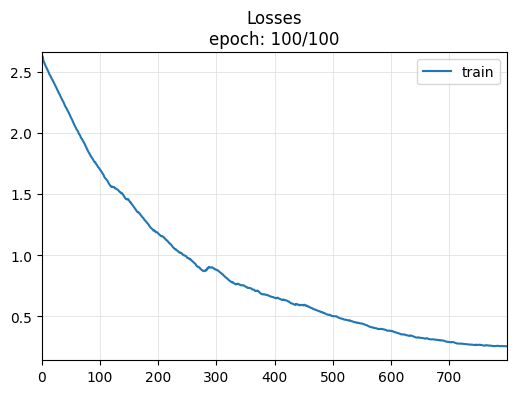

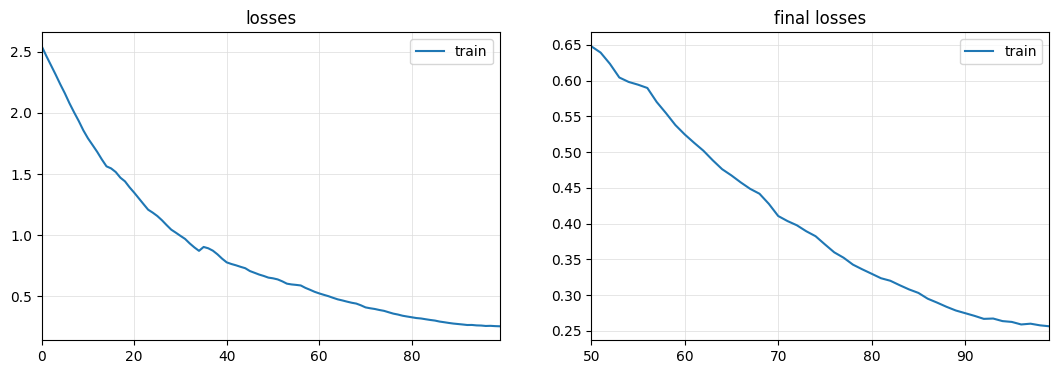

In [80]:
learn = ts_learner(dls, InceptionTime, metrics=accuracy , cbs=ShowGraph())
learn.fit_one_cycle(100)

In [81]:
X_t, y_t, splits = combine_split_data([X_test], [y_test])
probas, targets, preds = learn.get_X_preds(X_t, y_t, with_decoded=True)

In [85]:
it_y_preds = np.argmax(probas, axis=-1)
accuracy = accuracy_score(y_t, it_y_preds)
print(f"InceptionTime Accuracy: {accuracy*100:.4f}%")
# top5_accuracy = compute_top_5_accuracy(y_test, it_y_preds)
# print(f'InceptionTime top 5 Accuracy: {top5_accuracy*100:.4f}%')

InceptionTime Accuracy: 86.0465%
